# Assignment 2
## Steve Cheney
### RBIF110



In [6]:
%pip install openbabel-wheel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Problem 1

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import SaltRemover, PandasTools
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import RDLogger

from openbabel import pybel as pb

In [8]:
# Read in the data files

# Assuming you conver the xls to a csv

lc50_data = "FishLC50.csv"
try:
    lc50_df = pd.read_csv(lc50_data, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    lc50_df = pd.read_csv(lc50_data, sep=",", encoding="latin-1")



bbb_data = "BBB_Data.txt"
try:
    bbb_df = pd.read_csv(bbb_data, sep="\t", encoding="utf-8")
except UnicodeDecodeError:
    bbb_df = pd.read_csv(bbb_data, sep="\t", encoding="latin-1")

#lc50_df.head()
#bbb_df.head()


In [9]:
print(lc50_df.columns)

Index(['STRUCTURE_SMILES', 'LC50_mmol'], dtype='object')


In [10]:
def standardize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''

    # Handle any issues with missing values
    if not isinstance(smiles, str) or smiles.strip() == "" or pd.isna(smiles):
        return None
    
    mol = Chem.MolFromSmiles(smiles) #create a mol object from input smiles


    largest_Fragment = rdMolStandardize.LargestFragmentChooser()    
    standardized_smiles = largest_Fragment.choose(mol) #standardize the input string by taking the largest fragment

    canonical_smiles = Chem.MolToSmiles(standardized_smiles) #convert the previous mol object to SMILES using Chem.MolToSmiles()

    ####END
    return canonical_smiles

def get_standard_mol(smiles):
    '''This function takes a non-canonical SMILES converts to the canonical version, then returns the mol object

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - obj: mol object of the converted canonical molecule
    '''
    
    if smiles is None:
        return None

    try:
        mol_obj = Chem.MolFromSmiles(standardize_smiles(smiles))
        return mol_obj if mol_obj else None
    except:
        return None

def get_fingerprint(mol, radius=2, bits=1024):
    if mol is None:
        return None  # Prevents passing None to the RDKit function
    
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bits)

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')  # Disables all RDKit logging messages

def clean_df_and_create_mol_col(df, smilesCol, molCol, subset_len=-1, remove_na=True):

    if subset_len == -1:
        data_subset = df.copy()
    else:
        data_subset = df.iloc[:subset_len].copy()

    # Clean data
    data_subset = data_subset[data_subset[smilesCol].notna()]  # Remove NaN values
    data_subset[smilesCol] = data_subset[smilesCol].astype(str)  # Ensure all values are strings

    PandasTools.AddMoleculeColumnToFrame(data_subset, smilesCol=smilesCol, molCol=molCol)

    return data_subset

def calculate_descriptors(mol):
    if mol:
        return {
            "Molecular_Weight": Descriptors.MolWt(mol),
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
            "Aromatic_Bonds": rdMolDescriptors.CalcNumAromaticRings(mol),
            "ClogP": Descriptors.MolLogP(mol),
            "TPSA": Descriptors.TPSA(mol),
        }
    else:
        return None

In [11]:
# Clean the data to ignore any NaN smiles values and subset data if needed
lc50_df = clean_df_and_create_mol_col(lc50_df, 'STRUCTURE_SMILES', 'rdkit_mol')
# Get the standardized mol object from the standard SMILES
lc50_df['standardized_mol'] = lc50_df['STRUCTURE_SMILES'].apply(get_standard_mol)
# Get the fingerprint
lc50_df['fingerprint'] = lc50_df['standardized_mol'].apply(get_fingerprint)
lc50_df.head()

STRUCTURE_SMILES  LC50_mmol  \
0     OCCN(CCO)CCO     79.100   
1           CN(C)N      0.131   
2            NCCCN     16.100   
3          OCCNCCO     44.800   
4          CS(=O)C    435.000   

                                           rdkit_mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   
1  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   
2  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   
3  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   
4  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   

                                    standardized_mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x0000021D016...   
1  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   
2  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   
3  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   
4  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   

                                         fingerprint  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

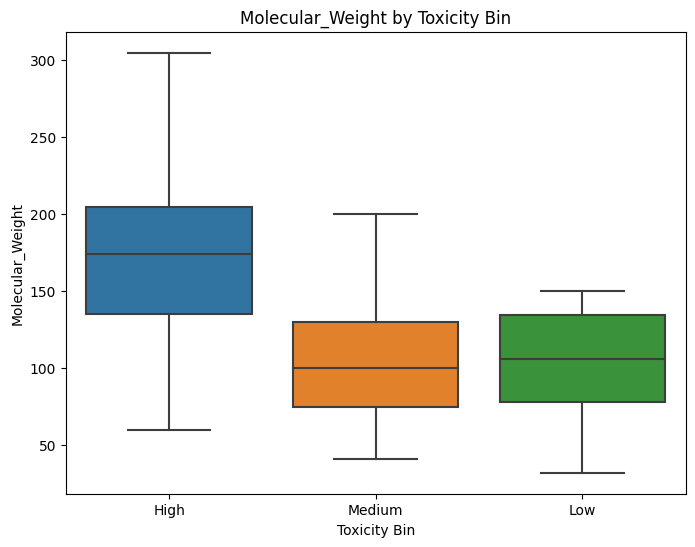

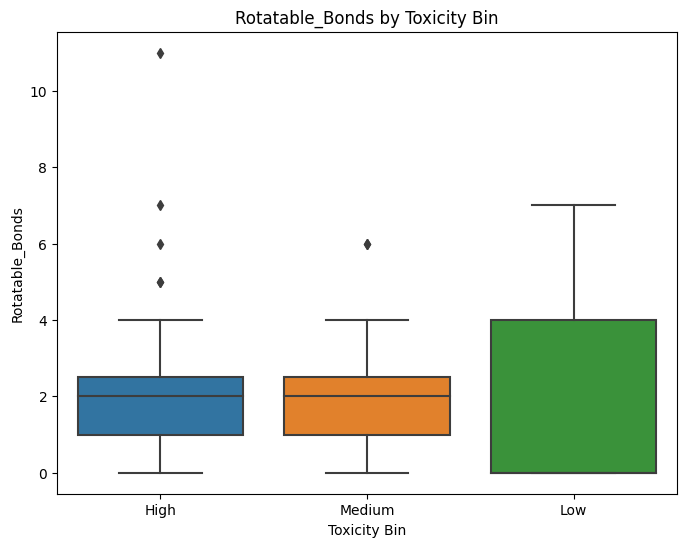

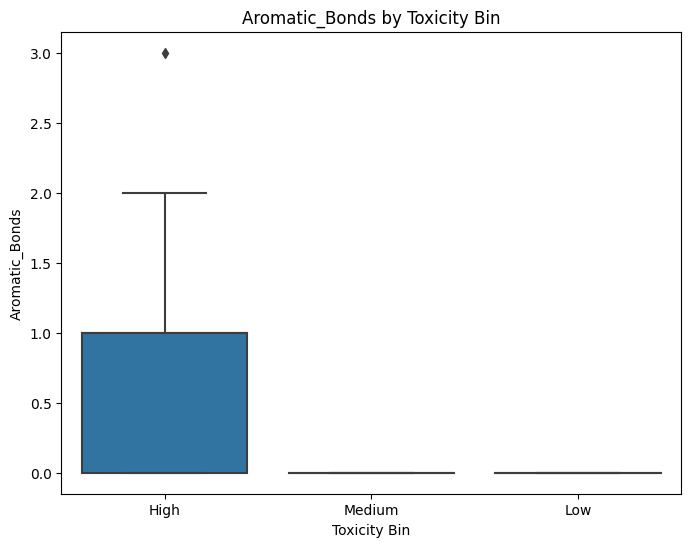

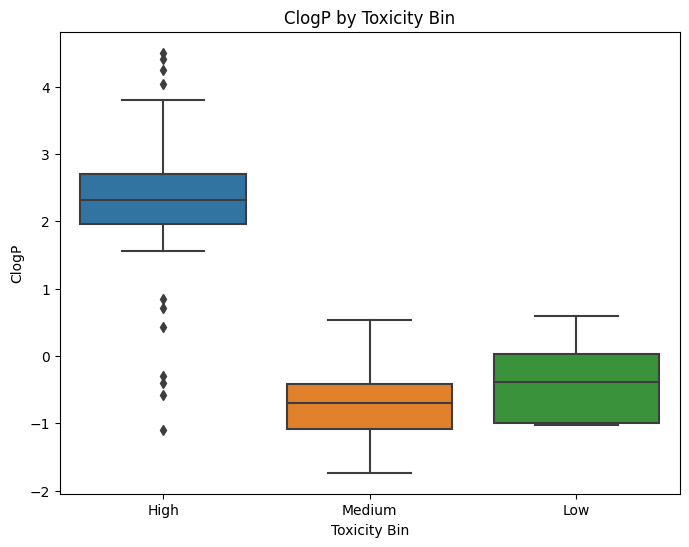

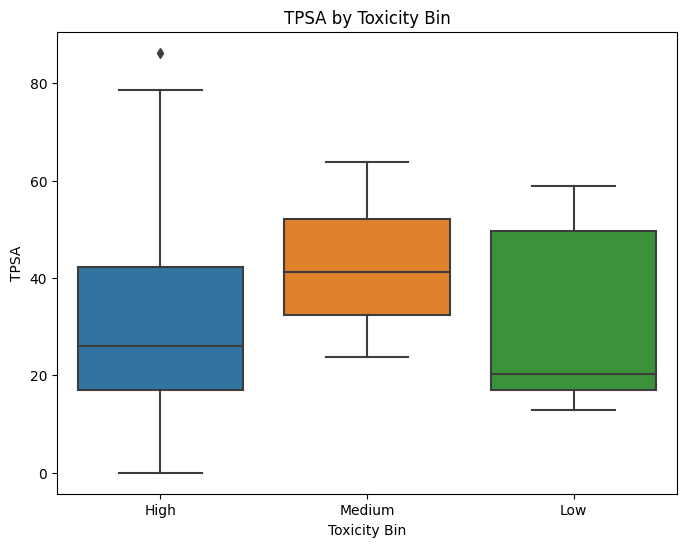

c:\Users\Stephen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


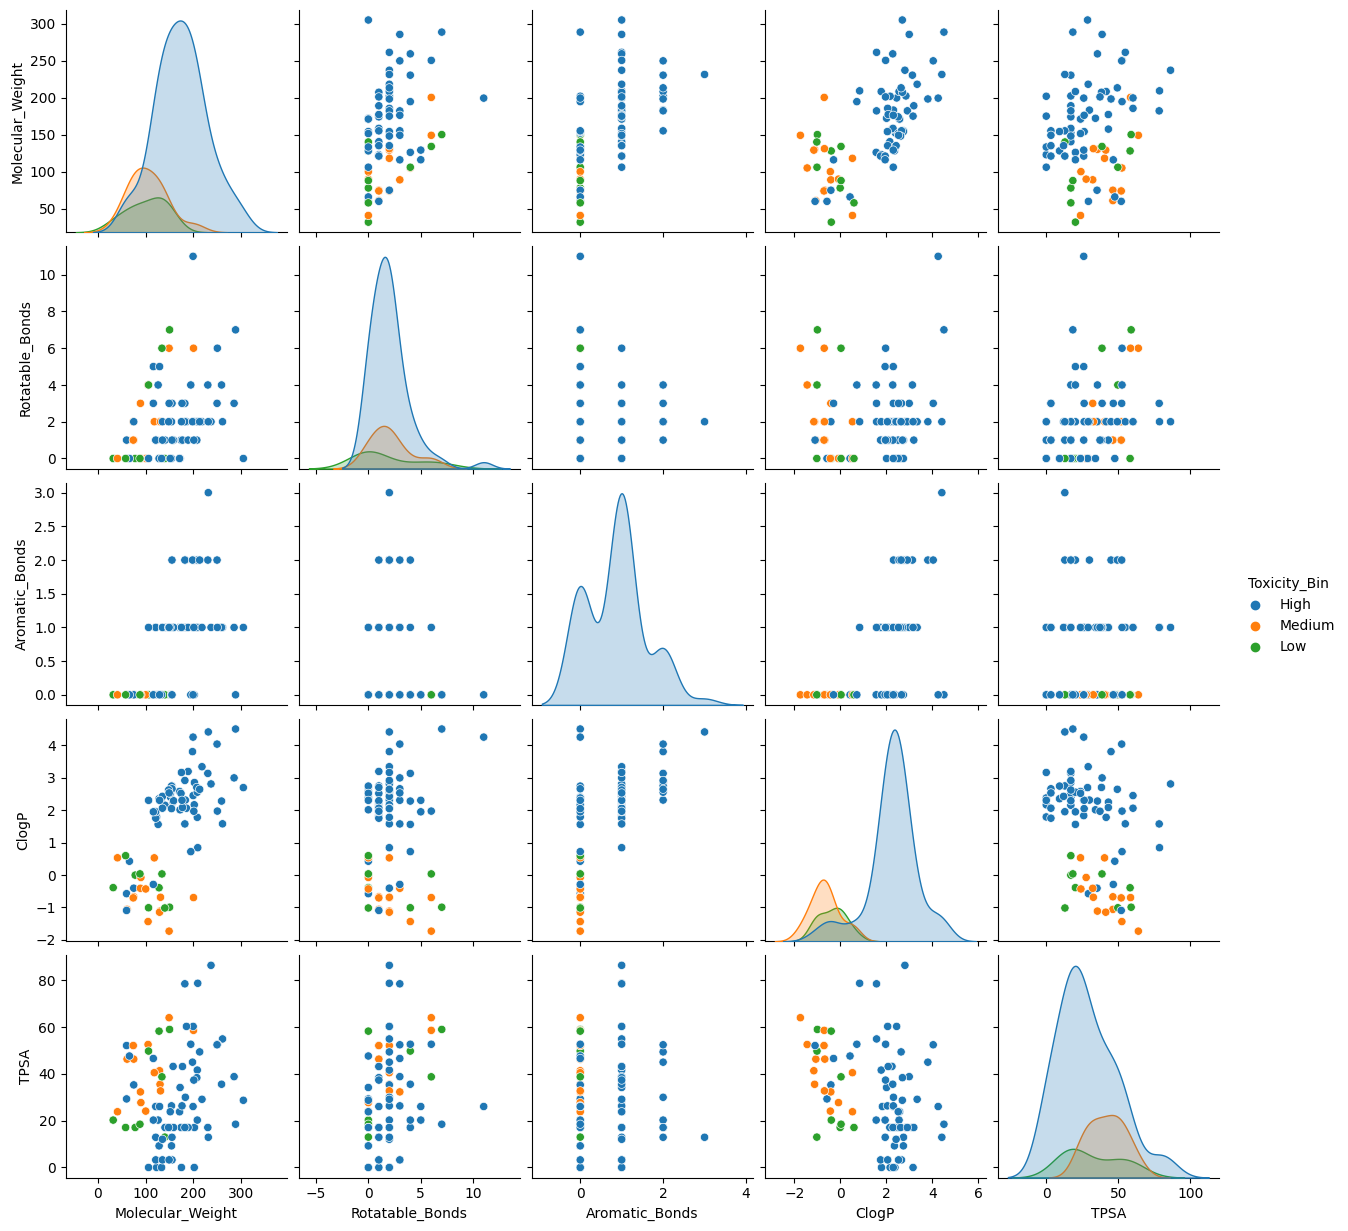

In [12]:
descriptor_data = lc50_df["standardized_mol"].apply(calculate_descriptors)
descriptor_df = pd.DataFrame(descriptor_data.tolist())
lc50_df = pd.concat([lc50_df, descriptor_df], axis=1)

# Bin LC50 values into categories
bins = [0, 10, 100, lc50_df['LC50_mmol'].max()]
labels = ["High", "Medium", "Low"]
lc50_df["Toxicity_Bin"] = pd.cut(lc50_df["LC50_mmol"], bins=bins, labels=labels)


# Boxplots for each descriptor by toxicity bin
for col in ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=lc50_df, x="Toxicity_Bin", y=col)
    plt.title(f"{col} by Toxicity Bin")
    plt.ylabel(col)
    plt.xlabel("Toxicity Bin")
    plt.show()

# Pair plot to explore relationships between descriptors
sns.pairplot(lc50_df, vars=["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"], hue="Toxicity_Bin")
plt.show()

For Molecular Weight, compounds in the high-toxicity bin tend to have higher molecular weights compared to medium- and low-toxicity bins. This pattern may indicate that larger compounds, potentially with more complex structures, correlate with higher toxicity levels. Similarly, Rotatable Bonds display a noticeable trend where low-toxicity compounds tend to have a greater number of rotatable bonds. This may suggest that structural flexibility plays a role in reducing toxicity. Aromatic Bonds, on the other hand, are predominantly present in the high-toxicity bin, with little to no aromaticity in medium- and low-toxicity compounds, indicating that aromatic structures are more associated with toxicity.

For ClogP, a measure of lipophilicity, compounds in the high-toxicity bin exhibit consistently higher values than those in the medium- and low-toxicity bins, suggesting a potential relationship between increased lipophilicity and greater toxicity. The TPSA values, however, display less variation between the bins, with medium-toxicity compounds showing slightly higher median values compared to high- and low-toxicity compounds. The pair plot further illustrates these relationships, with clear clustering of toxicity bins based on combinations of descriptors like Molecular Weight and Rotatable Bonds.

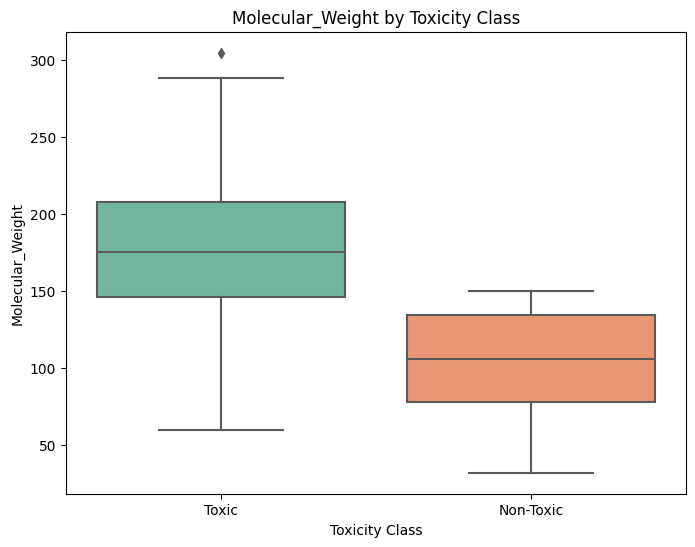

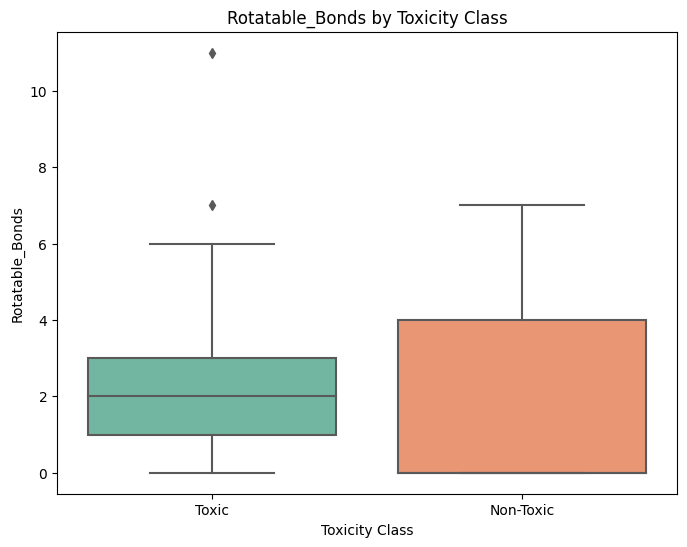

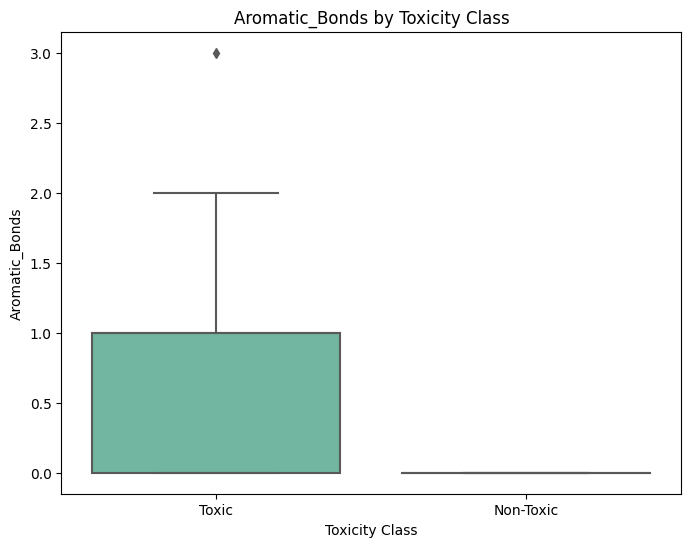

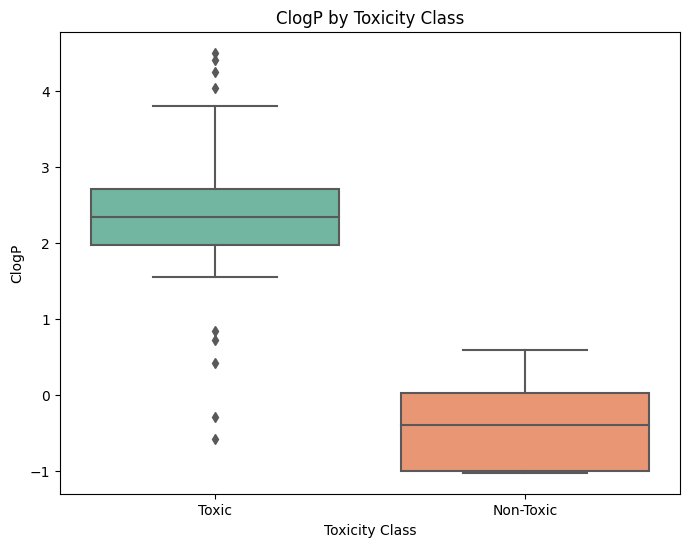

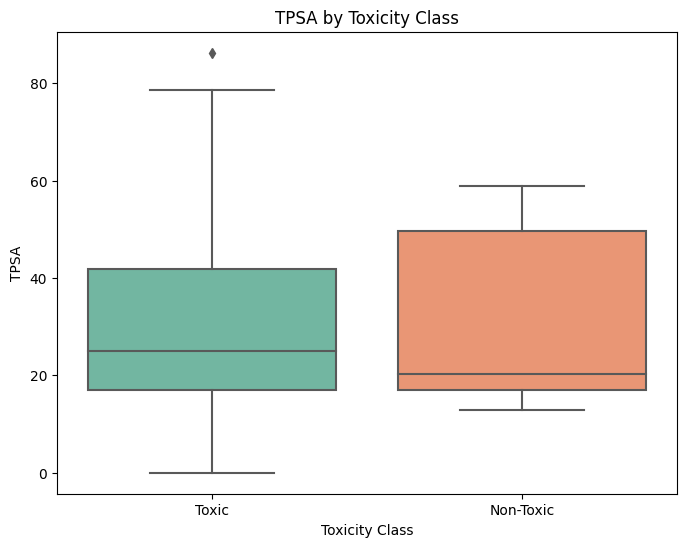

c:\Users\Stephen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


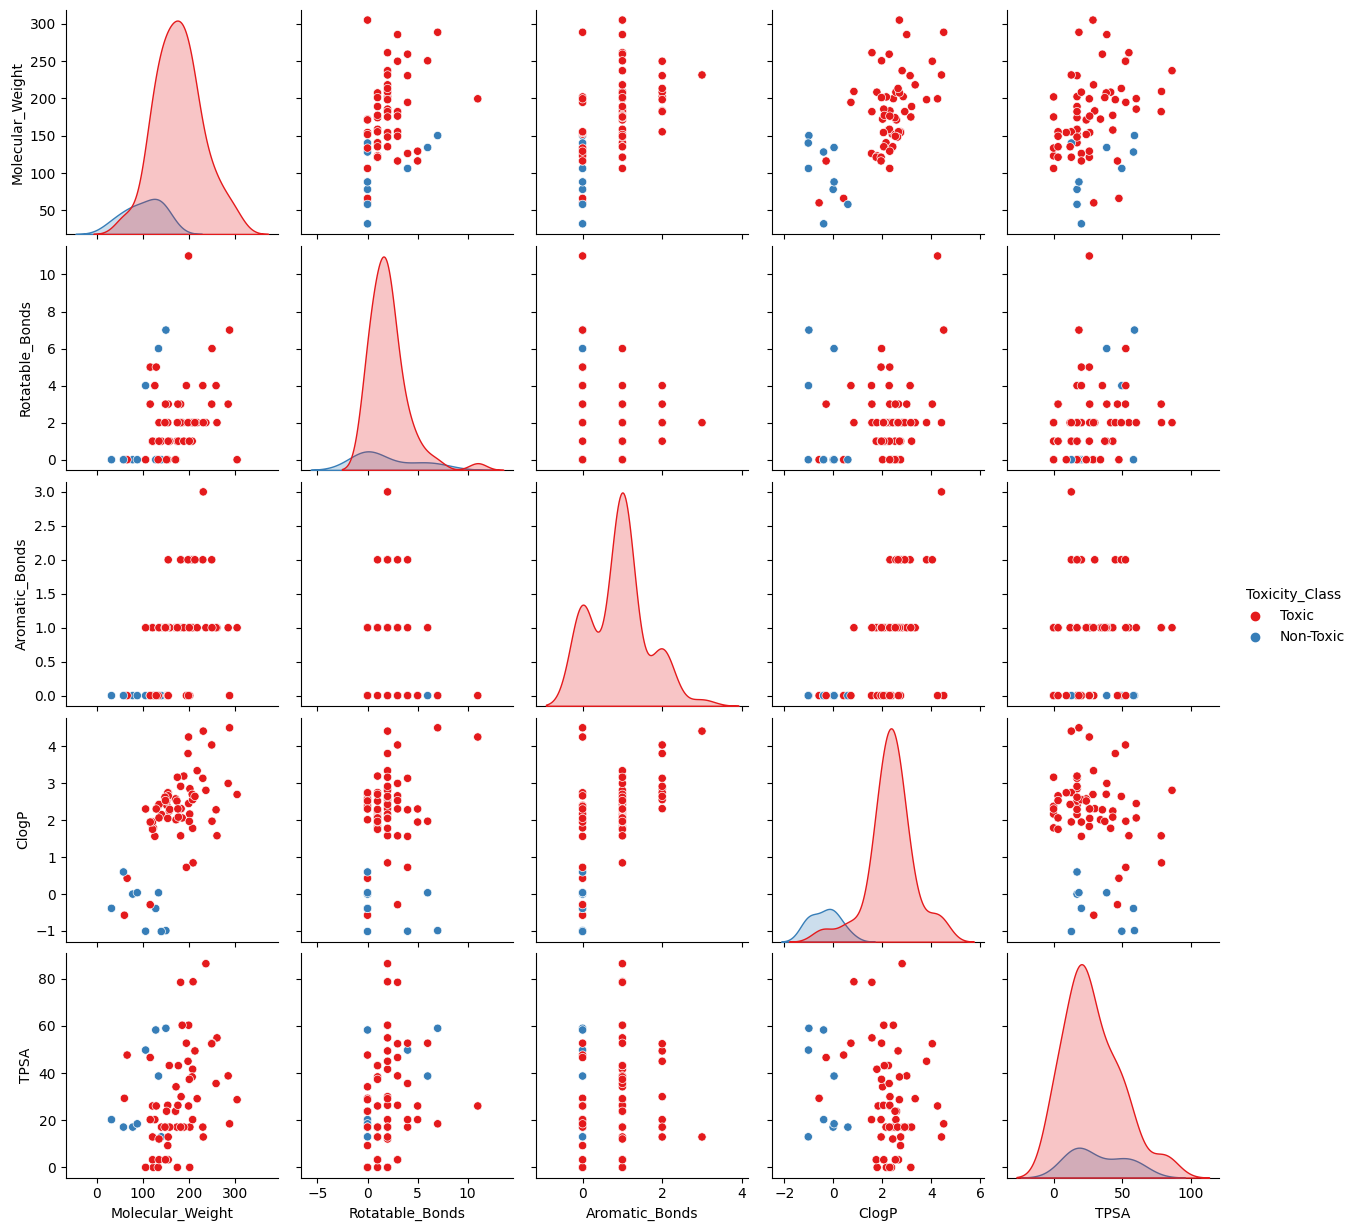

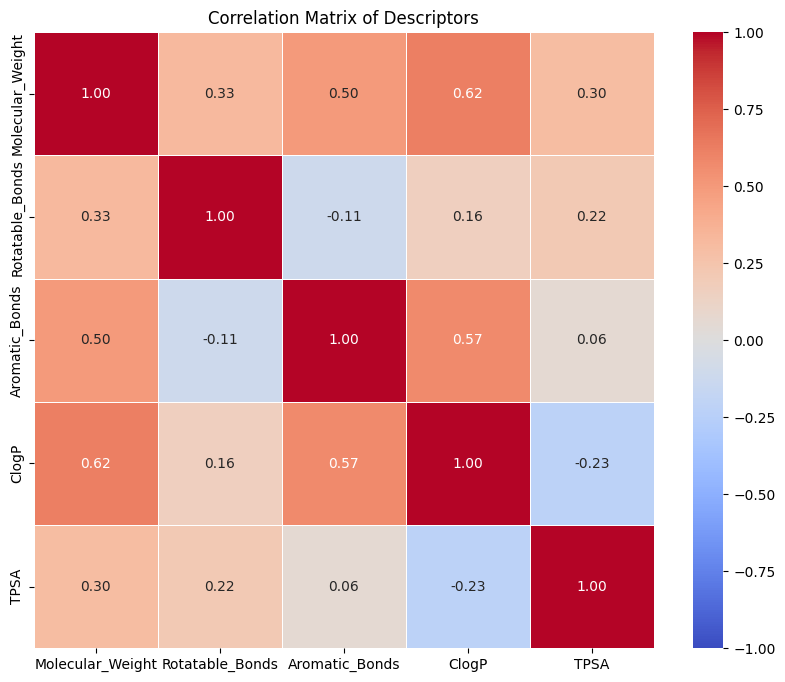

In [13]:
# Filter the dataset to include only Toxic (LC50 <= 1) and Non-Toxic (LC50 > 100); see citation [1]
filtered_lc50_df = lc50_df[(lc50_df["LC50_mmol"] <= 1) | (lc50_df["LC50_mmol"] > 100)].copy()
filtered_lc50_df["Toxicity_Class"] = np.where(filtered_lc50_df["LC50_mmol"] <= 1, "Toxic", "Non-Toxic")

# Boxplots for each descriptor by Toxicity_Class
for col in ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=filtered_lc50_df, x="Toxicity_Class", y=col, palette="Set2")
    plt.title(f"{col} by Toxicity Class")
    plt.ylabel(col)
    plt.xlabel("Toxicity Class")
    plt.show()

sns.pairplot(
    filtered_lc50_df,
    vars=["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"],
    hue="Toxicity_Class",
    palette="Set1"
)
plt.show()

descriptor_cols = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]
corr_matrix = filtered_lc50_df[descriptor_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Descriptors")
plt.show()



Moving on to a Toxic (LC50 ≤ 1) vs. Non-Toxic (LC50 > 100) analysis, the boxplots and pair plots for the binary classification reveal some more distinct trends in molecular descriptors. The binary classification was calculated based on this paper and their suggested classification for multiple species [1]. Toxic compounds generally have higher molecular weights compared to Non-Toxic ones, as shown by the higher medians and broader distribution in the "Toxic" class, which is in line with results from before. Similarly, the number of aromatic bonds is predominantly higher in the Toxic class, with almost no aromaticity observed in Non-Toxic compounds. Conversely, Non-Toxic compounds tend to have more rotatable bonds, indicating greater structural flexibility. The ClogP values, a measure of lipophilicity, also show a clear distinction, with Toxic compounds being more lipophilic (higher ClogP), while Non-Toxic compounds are more hydrophilic (lower ClogP). TPSA (Topological Polar Surface Area), however, exhibits comparable medians across the two classes, though Toxic compounds display greater variability.

The pair plot highlights relationships between descriptors, with the Toxic and Non-Toxic classes forming distinct clusters in some descriptor combinations. For example, Molecular Weight and Rotatable Bonds exhibit a clear separation between the two classes, with Non-Toxic compounds occupying a lower molecular weight and higher rotatable bond region. The correlation heatmap further supports these findings, showing moderate to strong positive correlations between Molecular Weight and descriptors like Rotatable Bonds and Aromatic Bonds. ClogP is also positively correlated with Molecular Weight and Aromatic Bonds, particularly in Toxic compounds. Overall, the analysis reveals that higher molecular weight, increased aromaticity, and higher lipophilicity are more characteristic of Toxic compounds, whereas greater flexibility and lower molecular weight are associated with Non-Toxic compounds.

1. Lane, T. R., Harris, J., Urbina, F., & Ekins, S. (2023). Comparing LD50/LC50 Machine Learning Models for Multiple Species. Journal of chemical health & safety, 30(2), 83–97. https://doi.org/10.1021/acs.chas.2c00088

## Problem 2

In [14]:
bbb_df = clean_df_and_create_mol_col(bbb_df, 'smiles', 'rdkit_mol')
bbb_df['standardized_mol'] = bbb_df['smiles'].apply(get_standard_mol)
bbb_df['fingerprint'] = bbb_df['standardized_mol'].apply(get_fingerprint)
bbb_df.head()

num                  name p_np  \
0    1            Propanolol    p   
1    2  Terbutylchlorambucil    p   
2    3                 40730    p   
3    4                    24    p   
4    5           cloxacillin    p   

                                              smiles  \
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12   
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl   
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...   
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C   
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...   

                                           rdkit_mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x0000021D051...   
1  <rdkit.Chem.rdchem.Mol object at 0x0000021D051...   
2  <rdkit.Chem.rdchem.Mol object at 0x0000021D051...   
3  <rdkit.Chem.rdchem.Mol object at 0x0000021D051...   
4  <rdkit.Chem.rdchem.Mol object at 0x0000021D051...   

                                    standardized_mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x0000021D01C...   
1  <rdkit.Chem.rdchem.Mol object at 0x0000021D0A8...   
2  <rdkit.Chem.rdchem.Mol object at 0x0000021D0A8...   
3  <rdkit.Chem.rdchem.Mol object at 0x0000021D0A8...   
4  <rdkit.Chem.rdchem.Mol object at 0x0000021D0A8...   

                                         fingerprint  
0  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
3  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...  
4  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [20]:
def smiles_to_sdf(dataframe, smiles_col, output_sdf):
    # Create a Pybel molecule object for each SMILES
    molecules = []
    for idx, row in dataframe.iterrows():
        smiles = row[smiles_col]
        mol = pb.readstring("smi", smiles)  # Read the SMILES string
        mol.title = row["name"]  # Set molecule name

        # Add custom properties (e.g., p_np) to the molecule
        if "p_np" in row:
            mol.data["p_np"] = row["p_np"]  # Add the p_np property

        molecules.append(mol)
    
    # Write to an SDF file
    with pb.Outputfile("sdf", output_sdf, overwrite=True) as sdf_file:
        for mol in molecules:
            sdf_file.write(mol)

def extract_properties_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    data = []
    for mol in supplier:
        if mol is not None:  # Ensure valid molecule
            props = {
                "name": mol.GetProp("_Name"),
                "p_np": mol.GetProp("p_np") if mol.HasProp("p_np") else None,
                "Molecular_Weight": Descriptors.MolWt(mol),
                "LogP": Descriptors.MolLogP(mol),
                "H_Bond_Donors": Descriptors.NumHDonors(mol),
                "H_Bond_Acceptors": Descriptors.NumHAcceptors(mol),
                "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
                "TPSA": Descriptors.TPSA(mol),
            }
            data.append(props)
    return pd.DataFrame(data)

smiles_to_sdf(bbb_df, smiles_col="smiles", output_sdf="bbb.sdf")

Summary statistics for Penetrant:
       Molecular_Weight         LogP  H_Bond_Donors  H_Bond_Acceptors  \
count       1563.000000  1563.000000    1563.000000       1563.000000   
mean         315.675381     2.670754       1.050544          3.732566   
std          112.364566     1.735716       1.063601          2.144315   
min           28.054000   -11.744600       0.000000          0.000000   
25%          246.308000     1.642350       0.000000          2.000000   
50%          307.437000     2.791500       1.000000          3.000000   
75%          382.460000     3.882000       2.000000          5.000000   
max         1136.115000    10.056300      13.000000         24.000000   

       Rotatable_Bonds         TPSA  
count      1563.000000  1563.000000  
mean          3.809341    53.576136  
std           2.756343    36.899122  
min           0.000000     0.000000  
25%           2.000000    29.100000  
50%           3.000000    46.610000  
75%           6.000000    73.535000  
max 

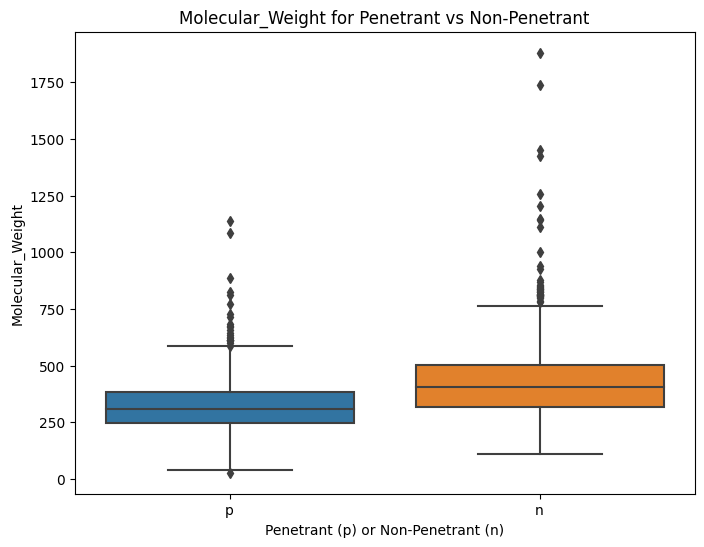

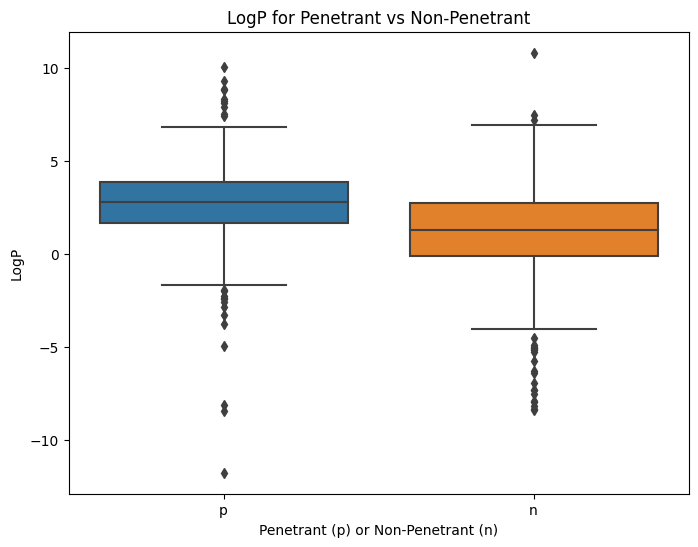

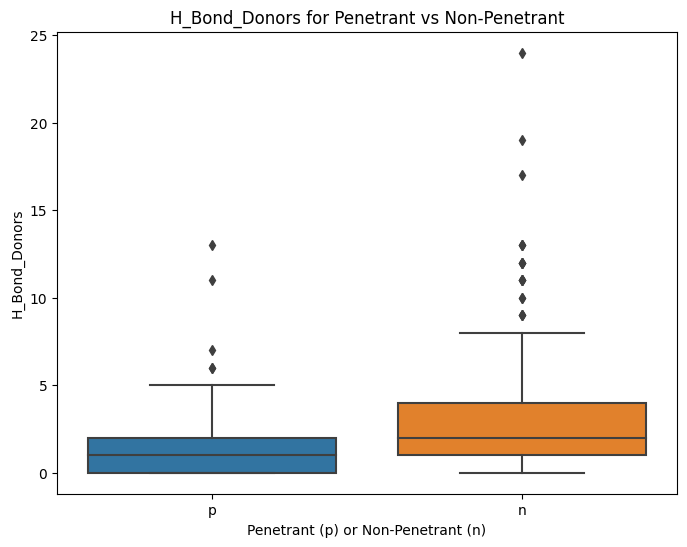

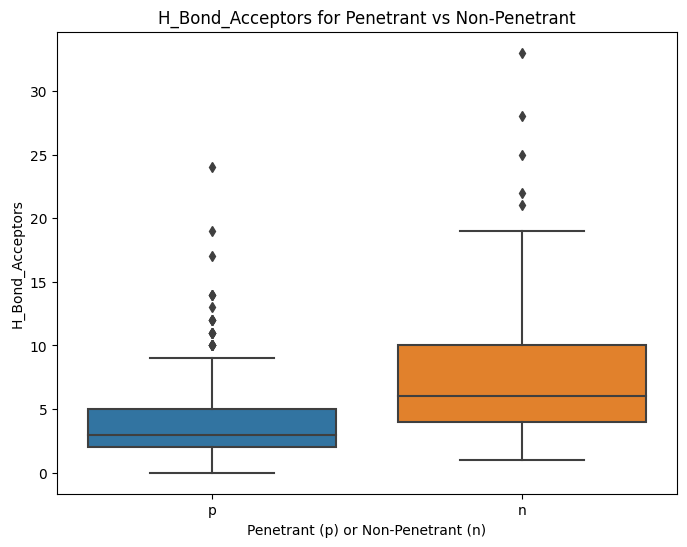

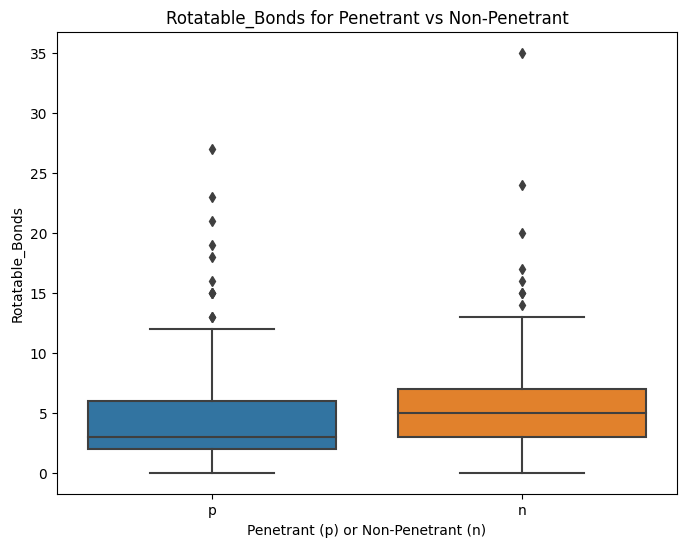

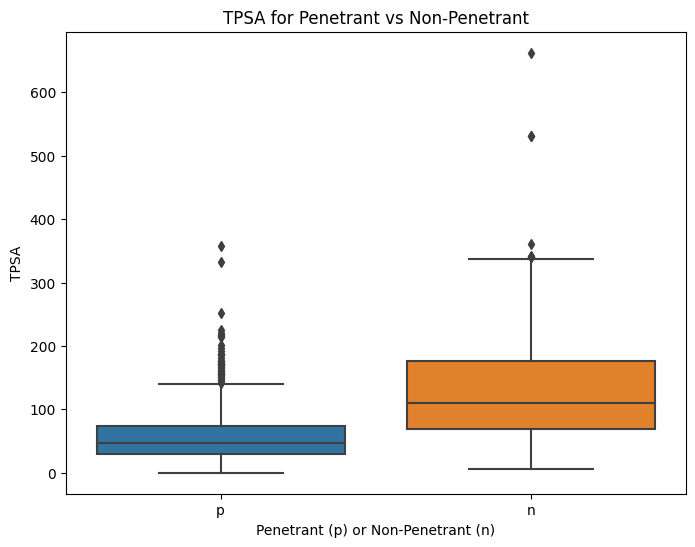

In [21]:
properties_df = extract_properties_from_sdf("bbb.sdf")

# Group by penetrant (p) or non-penetrant (n)
penetrant_df = properties_df[properties_df["p_np"] == "p"]
nonpenetrant_df = properties_df[properties_df["p_np"] == "n"]

# Summary statistics for each group
summary_stats = {
    "Penetrant": penetrant_df.describe(),
    "Non-Penetrant": nonpenetrant_df.describe(),
}

for group, stats in summary_stats.items():
    print(f"Summary statistics for {group}:")
    print(stats)

properties_to_compare = ["Molecular_Weight", "LogP", "H_Bond_Donors", "H_Bond_Acceptors", "Rotatable_Bonds", "TPSA"]
for prop in properties_to_compare:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=properties_df, x="p_np", y=prop)
    plt.title(f"{prop} for Penetrant vs Non-Penetrant")
    plt.xlabel("Penetrant (p) or Non-Penetrant (n)")
    plt.ylabel(prop)
    plt.show()

### 1)
Looking at the above properties, Molecular_Weight, LogP, H Bond Donors, H Bond Acceptors, Rotatable_Bonds, and TPSA, we can see some of these properties have more of a difference in penetrance. Of note, H Bond Acceptors, TPSA and Molecular weight seem to play more of a role in non-penetrance. Conversely, the LogP property seems to favor more penetrant more. 


Logistic Regression Coefficients:
  Molecular_Weight: -0.2400
  LogP: 0.2489
  H_Bond_Donors: -0.7167
  H_Bond_Acceptors: 0.0546
  Rotatable_Bonds: -0.0423
  TPSA: -0.8072

Logistic Regression AUC-ROC: 0.8402

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.43      0.55       479
           1       0.85      0.96      0.90      1563

    accuracy                           0.84      2042
   macro avg       0.81      0.70      0.73      2042
weighted avg       0.83      0.84      0.82      2042



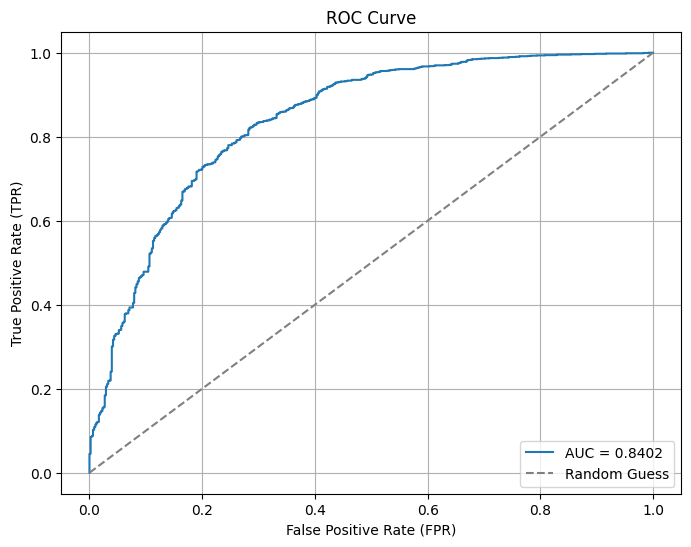

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


# Combine all properties for logistic regression
X = properties_df[properties_to_compare]
y = (properties_df["p_np"] == "p").astype(int)  # 1 for penetrant, 0 for non-penetrant

# Standardize features and fit the log reg model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LogisticRegression()
model.fit(X_scaled, y)

# Print coefficients
print("\nLogistic Regression Coefficients:")
for feature, coef in zip(properties_to_compare, model.coef_[0]):
    print(f"  {feature}: {coef:.4f}")

# Model performance metrics
y_pred = model.predict(X_scaled)
roc_auc = roc_auc_score(y, model.predict_proba(X_scaled)[:, 1])

print(f"\nLogistic Regression AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y, model.predict_proba(X_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 2)

Among the predictors, TPSA (Topological Polar Surface Area) and H-Bond Donors have the strongest negative influence on penetrance, with higher values in these properties significantly reducing the likelihood of penetration. This suggests that compounds with greater polarity or the ability to form hydrogen bonds are less likely to penetrate. Conversely, LogP (lipophilicity) has the strongest positive effect, indicating that higher lipophilicity favors penetration. Molecular Weight also plays a role, with larger molecular weights being less favorable for penetrance, while Rotatable Bonds and H-Bond Acceptors have more minimal but still measurable impacts on the likelihood of penetration.

The model demonstrates strong predictive performance with an AUC-ROC of 0.84, indicating a good ability to distinguish between penetrant and non-penetrant compounds. For penetrant compounds, the model achieves a high precision of 0.85 and an impressive recall of 0.96, meaning most penetrant compounds are correctly identified. However, the model struggles more with non-penetrant compounds, showing lower precision (0.77) and recall (0.43), suggesting a tendency to misclassify some non-penetrant compounds as penetrant.

In [45]:
# Add predictions and probabilities to the DataFrame for analysis
properties_df["true_label"] = y  # True labels
properties_df["predicted_label"] = y_pred  # Predicted labels
properties_df["predicted_prob"] = model.predict_proba(X_scaled)[:, 1]  # Predicted probabilities

# Identify false predictions
false_positives = properties_df[(properties_df["true_label"] == 0) & (properties_df["predicted_label"] == 1)]
false_negatives = properties_df[(properties_df["true_label"] == 1) & (properties_df["predicted_label"] == 0)]

# Sort by closeness to being correct
false_positives_sorted = false_positives.sort_values(by="predicted_prob", ascending=False)
false_negatives_sorted = false_negatives.sort_values(by="predicted_prob", ascending=True)

print(f"Size of dataset: {len(properties_df)}")
print(f"\nNumber of False Positives: {len(false_positives_sorted)}({len(false_positives_sorted)/len(properties_df)*100:.4f}%)")
print(false_positives_sorted[["name", "true_label", "predicted_label", "predicted_prob"]].head())

print(f"\nNumber of False Negatives: {len(false_negatives_sorted)}({len(false_negatives_sorted)/len(properties_df)*100:.4f}%)")
print(false_negatives_sorted[["name", "true_label", "predicted_label", "predicted_prob"]].head())

Size of dataset: 2042

Number of False Positives: 273(13.3692%)
                 name  true_label  predicted_label  predicted_prob
302       mequitazine           0                1        0.961757
155      clotrimazole           0                1        0.955920
854       mecloxamine           0                1        0.955625
356  phenoxybenzamine           0                1        0.953449
354       pheniramine           0                1        0.952083

Number of False Negatives: 61(2.9873%)
                  name  true_label  predicted_label  predicted_prob
692           Amikacin           1                0        0.000280
169         Plicamycin           1                0        0.000532
1065        celucloral           1                0        0.010812
348   Calcium-folinate           1                0        0.046263
1258        folic-acid           1                0        0.062366


An interesting look into the False Positives and Negatives shows us that our False Positives are way more likely than Negatives to predict for penetrance. 